# In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every ten minutes, over several years. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

In [1]:
import os 

os.chdir('/Users/laolucharles1/Downloads') 
os.chdir('jena_climate') 


# The header of the Jena weather data

In [2]:
import os
data_dir = '/Users/laolucharles1/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


# Parsing the data

In [3]:
import numpy as np

# Initialize a NumPy array filled with zeros
float_data = np.zeros((len(lines), len(header) - 1)) #we use -1 because the first column has no meaning

# Loop through the lines of text data
for i, line in enumerate(lines):
    # Split each line by commas and convert the resulting values to float
    values = [float(x) for x in line.split(',')[1:]]
    # Assign the converted values to the i-th row of the float_data array
    float_data[i, :] = values

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

# Plotting the temperature timeseries

Text(0.5, 1.0, 'Temperature over Time in Degrees Celsius')

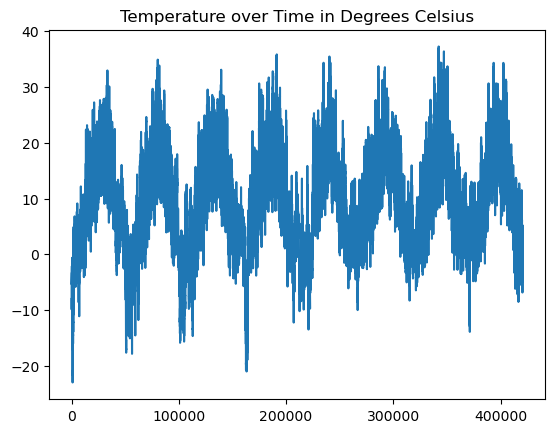

In [5]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.title('Temperature over Time in Degrees Celsius')

# Plotting the first ten days of the temperature timeseries

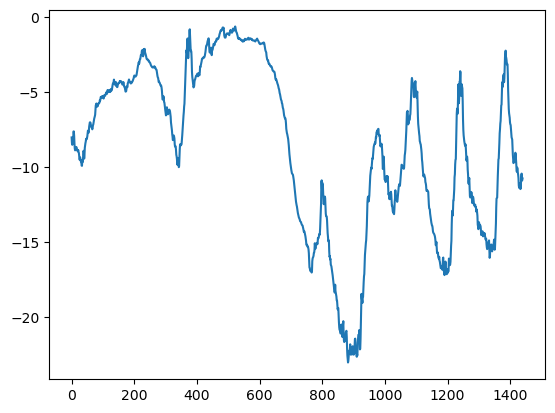

In [6]:
plt.plot(range(1440), temp[:1440]) 
# The data is recorded every 10 minutes so we get 144 data points per day

In [7]:
# The exact formulation of our problem will be the following: given data going as far back as lookback timesteps 
# (a timestep is 10 minutes) and sampled every steps timesteps, can we predict the temperature in delay timesteps?
# We will use the following parameter values:
# lookback = 720, i.e. our observations will go back 5 days.
# steps = 6, i.e. our observations will be sampled at one data point per hour. delay = 144, i.e. our targets will 
# be 24 hour in the future.

# Normalizing the data

In [21]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [25]:
print(std[1])
print(mean[1])

1.0000000000000446
-6.282735998119904e-15


# Generator yielding timeseries samples and their targets

In [9]:
#Now here is the data generator that we will use. It yields a tuple (samples, targets) where samples is one batch 
#of input data and targets is the corresponding array of target temperatures. It takes the following arguments:

# data: The original array of floating point data, which we just normalized in the code snippet above.
# lookback: How many timesteps back should our input data go (5 days)
# delay: How many timesteps in the future should our target be. (1 day/24hours/144 timesteps)
# min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for
# keeping a segment of the data for validation and another one for testing.
# shuffle: Whether to shuffle our samples or draw them in chronological order. 
# batch_size: The number of samples per batch.
# step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every 
# hour. (we will sample data every hour)

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1] #This is the temperature 24 hours in the future
        yield samples, targets

#  Preparing the training, validation and test generators

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size
# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# Creating a common sense, non-machine learning baseline model to compare the results to

In [11]:
#a common sense approach would be to always predict that the temperature 24 hours from now will be equal to the 
#temperature right now. Let’s evaluate this approach, using the Mean Absolute Error metric (MAE). 

# Computing the common-sense baseline MAE

In [40]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.28973597299053566


In [20]:
next?

In [46]:
#It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard 
# deviation of one, this number is not immediately interpretable. It translates to an average absolute error of 
# 0.29 * temperature_std degrees Celsius, i.e. 2.57°C. That’s a fairly large average absolute error—now the game 
# is to leverage our knowledge of deep learning to do better.

# A basic machine learning approach

In [47]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

2023-10-08 15:32:34.912493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 15:32:38.814161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/xx/mjmnx9zx0bjfztfkzwrdc_lc0000gn/T/ipykernel_41848/3204401368.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 6s 12ms/step - loss: 1.1594 - val_loss: 0.4759
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4084 - val_loss: 0.3268
Epoch 3/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2948 - val_loss: 0.3669
Epoch 4/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2680 - val_loss: 0.3076
Epoch 5/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2567 - val_loss: 0.3289
Epoch 6/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2457 - val_loss: 0.3722
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2407 - val_loss: 0.3326
Epoch 8/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2361 - val_loss: 0.3130
Epoch 9/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2302 - val_loss: 0.3209
Epoch 10/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2265 - val_lo

# Plotting results

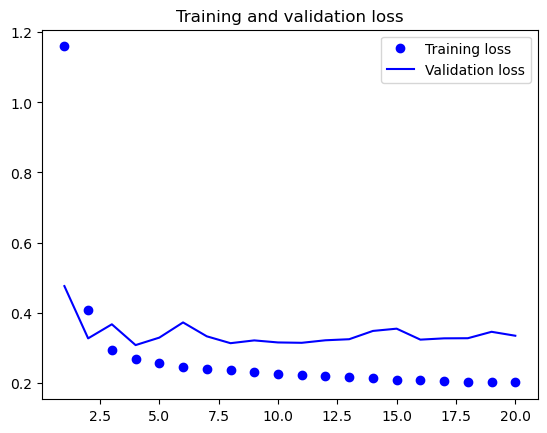

In [48]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Basic Machine Learning model is no better than our common sense model

# A first recurrent baseline

In [49]:
# the first BMLM did not take into account the fact that this is a 
# time series problem because no recurrent layers were used

# Training and evaluating a GRU-based model

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

2023-10-08 19:38:46.363674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 19:38:49.617500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/xx/mjmnx9zx0bjfztfkzwrdc_lc0000gn/T/ipykernel_57842/2161899563.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 45s 88ms/step - loss: 0.3020 - val_loss: 0.2710
Epoch 2/20
500/500 [==============================] - 45s 90ms/step - loss: 0.2854 - val_loss: 0.2634
Epoch 3/20
500/500 [==============================] - 42s 85ms/step - loss: 0.2793 - val_loss: 0.2642
Epoch 4/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2733 - val_loss: 0.2628
Epoch 5/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2686 - val_loss: 0.2666
Epoch 6/20
500/500 [==============================] - 42s 85ms/step - loss: 0.2644 - val_loss: 0.2616
Epoch 7/20
500/500 [==============================] - 43s 85ms/step - loss: 0.2612 - val_loss: 0.2625
Epoch 8/20
500/500 [==============================] - 43s 87ms/step - loss: 0.2587 - val_loss: 0.2633
Epoch 9/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2520 - val_loss: 0.2660
Epoch 10/20
500/500 [==============================] - 43s 85ms/step - loss: 0.248

# Plotting results

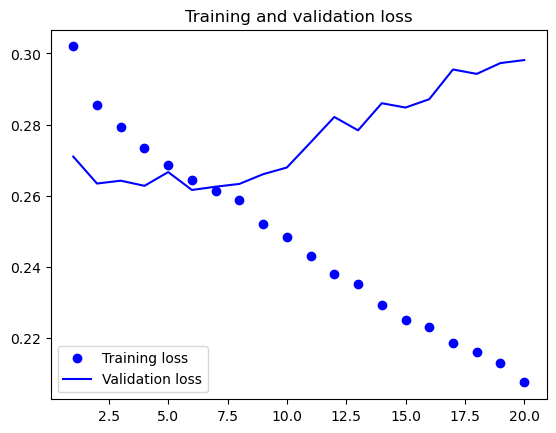

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
print(.265 * std[1] + mean[1])

0.26500000000000556


# Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task. Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35°C after de-normalization.

# Using recurrent dropout to fight overfitting

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/var/folders/xx/mjmnx9zx0bjfztfkzwrdc_lc0000gn/T/ipykernel_57842/1665531214.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 62s 120ms/step - loss: 0.3237 - val_loss: 0.2842
Epoch 2/40
500/500 [==============================] - 59s 119ms/step - loss: 0.3064 - val_loss: 0.2735
Epoch 3/40
500/500 [==============================] - 60s 119ms/step - loss: 0.2997 - val_loss: 0.2741
Epoch 4/40
500/500 [==============================] - 60s 120ms/step - loss: 0.2950 - val_loss: 0.2725
Epoch 5/40
500/500 [==============================] - 60s 120ms/step - loss: 0.2924 - val_loss: 0.2738
Epoch 6/40
500/500 [==============================] - 60s 120ms/step - loss: 0.2889 - val_loss: 0.2670
Epoch 7/40
500/500 [==============================] - 60s 119ms/step - loss: 0.2842 - val_loss: 0.2677
Epoch 8/40
500/500 [==============================] - 60s 120ms/step - loss: 0.2807 - val_loss: 0.2776
Epoch 9/40
500/500 [==============================] - 60s 119ms/step - loss: 0.2772 - val_loss: 0.2709
Epoch 10/40
500/500 [==============================] - 60s 120ms/step - loss: 0.2742

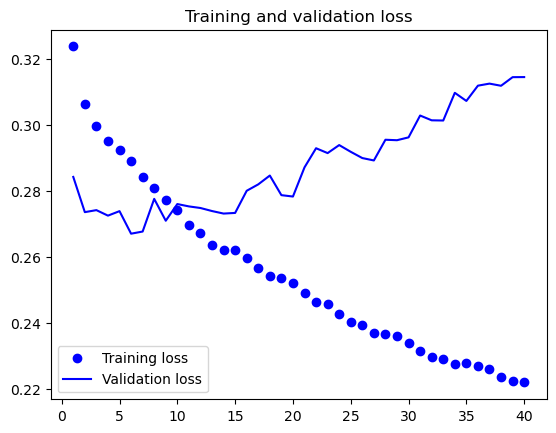

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Slightly less overfitting but overfitting nonetheless

# Stacking recurrent layers

In [29]:
# Since we are not overfitting as much, and we seem to have hit a performance bottleneck, we should start 
# considering increasing the capacity of our network. If you remember our description of the "universal machine 
# learning workflow": it is a generally a good idea to increase the capacity of your network until overfitting
# becomes your primary obstacle

# Training and evaluating a dropout-regularized stacked GRU model

In [31]:
# To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full 
# sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying 
# return_sequences=True:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/var/folders/xx/mjmnx9zx0bjfztfkzwrdc_lc0000gn/T/ipykernel_57842/3428763318.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 153s 301ms/step - loss: 0.3182 - val_loss: 0.2795
Epoch 2/40
500/500 [==============================] - 147s 294ms/step - loss: 0.3001 - val_loss: 0.2819
Epoch 3/40
500/500 [==============================] - 148s 295ms/step - loss: 0.2947 - val_loss: 0.2686
Epoch 4/40
500/500 [==============================] - 147s 294ms/step - loss: 0.2881 - val_loss: 0.2758
Epoch 5/40
500/500 [==============================] - 149s 299ms/step - loss: 0.2818 - val_loss: 0.2726
Epoch 6/40
500/500 [==============================] - 158s 315ms/step - loss: 0.2753 - val_loss: 0.2635
Epoch 7/40
500/500 [==============================] - 145s 290ms/step - loss: 0.2703 - val_loss: 0.2716
Epoch 8/40
500/500 [==============================] - 148s 296ms/step - loss: 0.2649 - val_loss: 0.2758
Epoch 9/40
500/500 [==============================] - 146s 292ms/step - loss: 0.2621 - val_loss: 0.2757
Epoch 10/40
500/500 [==============================] - 144s 289ms/step - lo

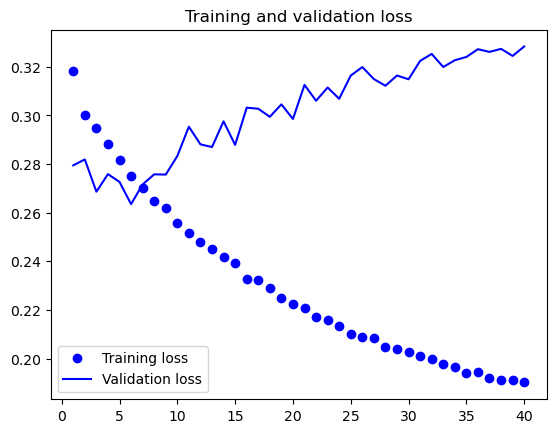

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Using bidirectional RNNs

In [33]:
#A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks.
#It is frequently used in natural language processing—you could call it the Swiss army knife of deep learning for
#NLP.

In [34]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/var/folders/xx/mjmnx9zx0bjfztfkzwrdc_lc0000gn/T/ipykernel_57842/3286772344.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 52s 98ms/step - loss: 0.2980 - val_loss: 0.2721
Epoch 2/20
500/500 [==============================] - 48s 97ms/step - loss: 0.2748 - val_loss: 0.2644
Epoch 3/20
500/500 [==============================] - 49s 97ms/step - loss: 0.2702 - val_loss: 0.2696
Epoch 4/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2625 - val_loss: 0.2749
Epoch 5/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2564 - val_loss: 0.2726
Epoch 6/20
500/500 [==============================] - 49s 97ms/step - loss: 0.2491 - val_loss: 0.2695
Epoch 7/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2431 - val_loss: 0.2784
Epoch 8/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2340 - val_loss: 0.2782
Epoch 9/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2289 - val_loss: 0.2841
Epoch 10/20
500/500 [==============================] - 49s 98ms/step - loss: 0.223

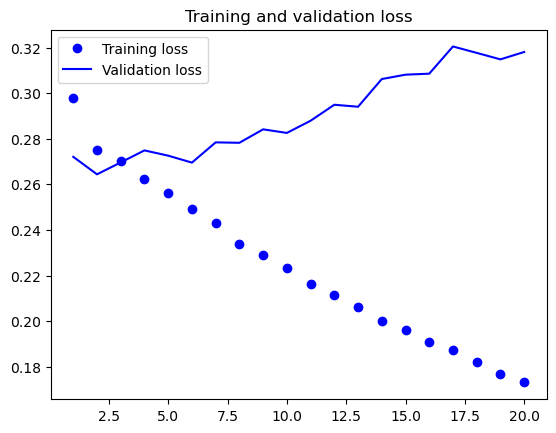

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()